In [2]:
#Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

In [3]:
#loading and showing head data
df = pd.read_csv('flight_data.csv', na_values=['NA'])
df.head(5)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,1/1/2013 5:00
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,1/1/2013 5:00
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,1/1/2013 5:00
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,1/1/2013 5:00
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,1/1/2013 6:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            336776 non-null  int64  
 1   month           336776 non-null  int64  
 2   day             336776 non-null  int64  
 3   dep_time        328521 non-null  float64
 4   sched_dep_time  336776 non-null  int64  
 5   dep_delay       328521 non-null  float64
 6   arr_time        328063 non-null  float64
 7   sched_arr_time  336776 non-null  int64  
 8   arr_delay       327346 non-null  float64
 9   carrier         336776 non-null  object 
 10  flight          336776 non-null  int64  
 11  tailnum         334264 non-null  object 
 12  origin          336776 non-null  object 
 13  dest            336776 non-null  object 
 14  air_time        327346 non-null  float64
 15  distance        336776 non-null  int64  
 16  hour            336776 non-null  int64  
 17  minute    

In [5]:
#Cleaning and formatting time columns
df['dep_time'] = df.dep_time[~df.dep_time.isna()].astype(np.int64).apply('{:0>4}'.format)
df['dep_time'] = pd.to_timedelta(df.dep_time.str[:2]+':'+df.dep_time.str[2:]+':00')

df['sched_dep_time'] = df.sched_dep_time[~df.sched_dep_time.isna()].astype(np.int64).apply('{:0>4}'.format)
df['sched_dep_time'] = pd.to_timedelta(df.sched_dep_time.str[:2]+':'+df.sched_dep_time.str[2:]+':00')

df['arr_time'] = df.arr_time[~df.arr_time.isna()].astype(np.int64).apply('{:0>4}'.format)
df['arr_time'] = pd.to_timedelta(df.arr_time.str[:2]+':'+df.arr_time.str[2:]+':00')

df['sched_arr_time'] = df.sched_arr_time[~df.sched_arr_time.isna()].astype(np.int64).apply('{:0>4}'.format)
df['sched_arr_time'] = pd.to_timedelta(df.sched_arr_time.str[:2]+':'+df.sched_arr_time.str[2:]+':00')

df[['dep_time','sched_dep_time', 'arr_time', 'sched_arr_time']] = df[['dep_time','sched_dep_time', 'arr_time', 'sched_arr_time']].apply(lambda x: pd.to_timedelta(x))

#We have 458 flights where flight dep_time is present but arr_time, arr_delay and air_time is missing, 
#So we can replace arr_time and arr_delay 

#Add minutes
def addMinutes(time, mins):
    return (pd.to_timedelta(time) + pd.Timedelta(minutes=mins))

#Replace arr_time with sched_arr_time + dep_delay
mask = (~df.dep_time.isna() & df.arr_time.isna())
df.loc[mask, "arr_time"] = df[mask].apply(lambda row: addMinutes(row['sched_arr_time'], row['dep_delay']), axis=1)

#Using proper data types
#df[['dep_time','sched_dep_time', 'arr_time', 'sched_arr_time']] = df[['dep_time','sched_dep_time', 'arr_time', 'sched_arr_time']].apply(lambda x: pd.to_timedelta(x))

#Replace arr_delay with arr_time - sched_arr_time
arr_delay_mask = (df.arr_time.notna() & df.arr_delay.isna())
df.loc[arr_delay_mask, "arr_delay"] = ((df.loc[arr_delay_mask, "arr_time"] - df.loc[arr_delay_mask, "sched_arr_time"]).astype('timedelta64[s]')//60)

#Arrival delay threshold is -100 mins
arr_delay_thresh_mask = (df.arr_delay.notna() & (df.arr_delay < -100))
df.loc[arr_delay_thresh_mask, "arr_delay"] = (1440 + df.loc[arr_delay_thresh_mask, "arr_delay"])

#Replace add missing air_time
air_time_mask = (df.dep_time.notna() & df.arr_time.notna() & df.air_time.isna())
df.loc[air_time_mask, "air_time"] = abs((df.loc[air_time_mask, "arr_time"] - df.loc[air_time_mask, "dep_time"]).astype('timedelta64[s]')//60)


# Create two columns with Ontime, Late and Cancelled status for both departure and arrival
df.loc[df.dep_delay.isna(), "dep_status"]="Canceled"
df.loc[df.dep_delay <= 0, "dep_status"]="OnTime"
df.loc[df.dep_delay > 0, "dep_status"]="Late"
df.loc[df.arr_delay.isna(), "arr_status"]="Canceled"
df.loc[df.arr_delay <= 0, "arr_status"]="OnTime"
df.loc[df.arr_delay > 0, "arr_status"]="Late"

#Dropping unwanted columns
df.drop("year", 1, inplace=True)
df.drop("hour", 1, inplace=True)
df.drop("minute", 1, inplace=True)
df.drop("tailnum", 1, inplace=True)
df.drop("time_hour", 1, inplace=True)

#Using proper data types 
df[['month','day', 'carrier', 'origin', 'dest', 'dep_status', 'arr_status']] = df[['month','day', 'carrier', 'origin', 'dest', 'dep_status', 'arr_status']].apply(lambda x: x.astype('category'))


/var/folders/4c/kzwxf5xn07ldpbsq9gwbzpqh0000gn/T/ipykernel_8635/2238927337.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop("year", 1, inplace=True)
/var/folders/4c/kzwxf5xn07ldpbsq9gwbzpqh0000gn/T/ipykernel_8635/2238927337.py:53: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop("hour", 1, inplace=True)
/var/folders/4c/kzwxf5xn07ldpbsq9gwbzpqh0000gn/T/ipykernel_8635/2238927337.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop("minute", 1, inplace=True)
/var/folders/4c/kzwxf5xn07ldpbsq9gwbzpqh0000gn/T/ipykernel_8635/2238927337.py:55: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop("tailnum", 1, inplace=True)
/va

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype          
---  ------          --------------   -----          
 0   month           336776 non-null  category       
 1   day             336776 non-null  category       
 2   dep_time        328521 non-null  timedelta64[ns]
 3   sched_dep_time  336776 non-null  timedelta64[ns]
 4   dep_delay       328521 non-null  float64        
 5   arr_time        328521 non-null  timedelta64[ns]
 6   sched_arr_time  336776 non-null  timedelta64[ns]
 7   arr_delay       328521 non-null  float64        
 8   carrier         336776 non-null  category       
 9   flight          336776 non-null  int64          
 10  origin          336776 non-null  category       
 11  dest            336776 non-null  category       
 12  air_time        328521 non-null  float64        
 13  distance        336776 non-null  int64          
 14  dep_status      3367

In [7]:
df.head(15)

,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,origin,dest,air_time,distance,dep_status,arr_status
0,1,1,0 days 05:17:00,0 days 05:15:00,2.0,0 days 08:30:00,0 days 08:19:00,11.0,UA,1545,EWR,IAH,227.0,1400,Late,Late
1,1,1,0 days 05:33:00,0 days 05:29:00,4.0,0 days 08:50:00,0 days 08:30:00,20.0,UA,1714,LGA,IAH,227.0,1416,Late,Late
2,1,1,0 days 05:42:00,0 days 05:40:00,2.0,0 days 09:23:00,0 days 08:50:00,33.0,AA,1141,JFK,MIA,160.0,1089,Late,Late
3,1,1,0 days 05:44:00,0 days 05:45:00,-1.0,0 days 10:04:00,0 days 10:22:00,-18.0,B6,725,JFK,BQN,183.0,1576,OnTime,OnTime
4,1,1,0 days 05:54:00,0 days 06:00:00,-6.0,0 days 08:12:00,0 days 08:37:00,-25.0,DL,461,LGA,ATL,116.0,762,OnTime,OnTime
5,1,1,0 days 05:54:00,0 days 05:58:00,-4.0,0 days 07:40:00,0 days 07:28:00,12.0,UA,1696,EWR,ORD,150.0,719,OnTime,Late
6,1,1,0 days 05:55:00,0 days 06:00:00,-5.0,0 days 09:13:00,0 days 08:54:00,19.0,B6,507,EWR,FLL,158.0,1065,OnTime,Late
7,1,1,0 days 05:57:00,0 days 06:00:00,-3.0,0 days 07:09:00,0 days 07:23:00,-14.0,EV,5708,LGA,IAD,53.0,229,OnTime,OnTime
8,1,1,0 days 05:57:00,0 days 06:00:00,-3.0,0 days 08:38:00,0 days 08:46:00,-8.0,B6,79,JFK,MCO,140.0,944,OnTime,OnTime
9,1,1,0 days 05:58:00,0 days 06:00:00,-2.0,0 days 07:53:00,0 days 07:45:00,8.0,AA,301,LGA,ORD,138.0,733,OnTime,Late


In [8]:
df.describe()

,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,flight,air_time,distance
count,328521,336776,328521.000000,328521,336776,328521.000000,336776.000000,328521.000000,336776.000000
mean,0 days 13:42:10.090131224,0 days 13:37:02.696629213,12.639070,0 days 15:13:12.569607422,0 days 15:33:26.591621730,7.329635,1971.923620,151.225736,1039.912604
std,0 days 04:52:43.859391633,0 days 04:41:08.833305461,40.210061,0 days 05:20:10.560649145,0 days 04:58:58.522489416,45.591673,1632.471938,95.297581,733.233033
min,0 days 00:01:00,0 days 01:06:00,-43.000000,0 days 00:01:00,0 days 00:01:00,-86.000000,1.000000,20.000000,17.000000
25%,0 days 09:07:00,0 days 09:06:00,-5.000000,0 days 11:05:00,0 days 11:24:00,-17.000000,553.000000,82.000000,502.000000
50%,0 days 14:01:00,0 days 13:59:00,-2.000000,0 days 15:36:00,0 days 15:56:00,-5.000000,1496.000000,130.000000,872.000000
75%,0 days 17:44:00,0 days 17:29:00,11.000000,0 days 19:41:00,0 days 19:45:00,14.000000,3465.000000,192.000000,1389.000000
max,1 days 00:00:00,0 days 23:59:00,1301.000000,1 days 02:29:00,0 days 23:59:00,1272.000000,8500.000000,1289.000000,4983.000000


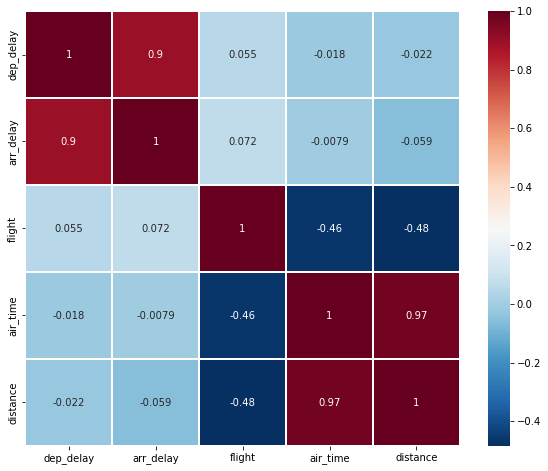

In [10]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu_r, linecolor='white', annot=True)
plt.show()

In [11]:
df1 = df
temp = df

In [12]:
buzAir = df.groupby(['origin'])['origin'].count()
buzAir

origin
EWR    120835
JFK    111279
LGA    104662
Name: origin, dtype: int64

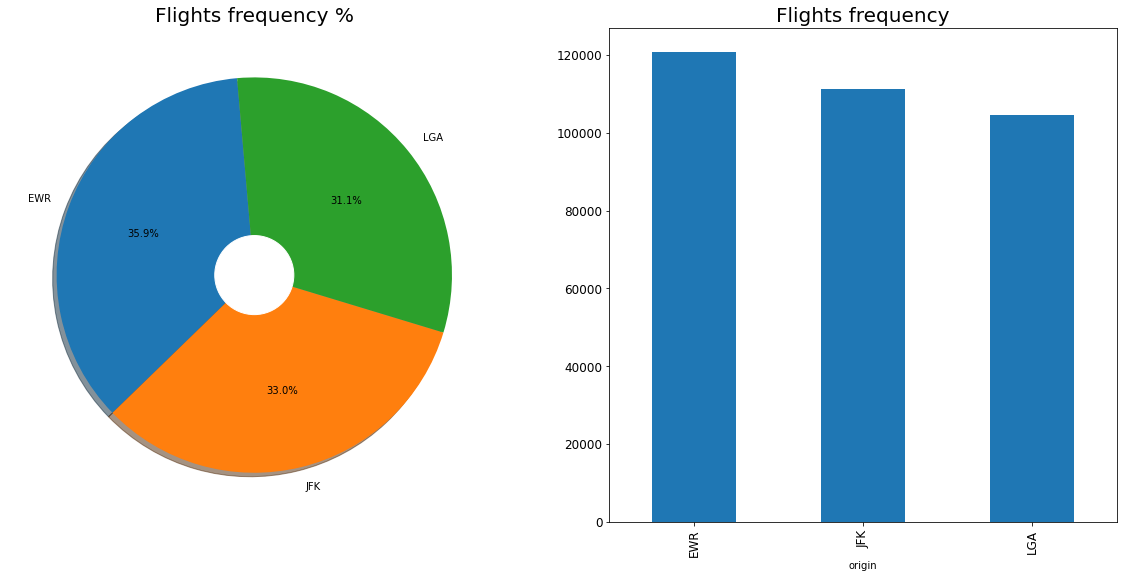

In [13]:
fig = plt.figure(figsize=[20, 20])
ax = fig.add_subplot(221)
ax.pie(buzAir, labeldistance=1.1, labels=buzAir.index, startangle=95, autopct='%1.1f%%', shadow=True)
ax.set_title("Flights frequency %", fontsize=20);
plt.gcf().gca().add_artist(plt.Circle( (0,0), 0.2, color='white'))

ax2 = fig.add_subplot(222)
ax2.set_title("Flights frequency", fontsize=20);
ax2.set_facecolor('white')
buzAir.plot(kind='bar', ax=ax2,  legend=False, fontsize=12)
plt.show()

In [14]:
buzMonth = df.groupby(['month'])['month'].count()
buzMonth

month
1     27004
2     24951
3     28834
4     28330
5     28796
6     28243
7     29425
8     29327
9     27574
10    28889
11    27268
12    28135
Name: month, dtype: int64

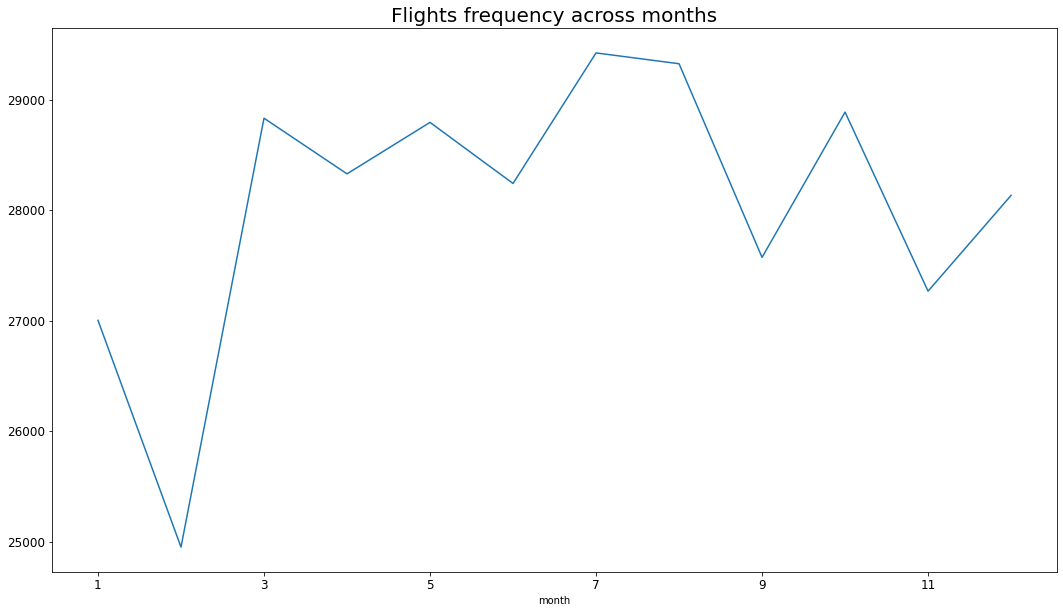

In [15]:
fig = plt.figure(figsize=[18, 10])
ax = fig.add_subplot(111)
ax.set_facecolor('white')
ax.set_title("Flights frequency across months", fontsize=20);
buzMonth.plot(ax=ax,  legend=False, fontsize=12)
plt.show()


In [16]:
depStatus = df.groupby('dep_status')['dep_status'].count()
arrStatus = df.groupby('arr_status')['arr_status'].count()
print(depStatus)
print()
print(arrStatus)

dep_status
Canceled      8255
Late        128432
OnTime      200089
Name: dep_status, dtype: int64

arr_status
Canceled      8255
Late        134032
OnTime      194489
Name: arr_status, dtype: int64


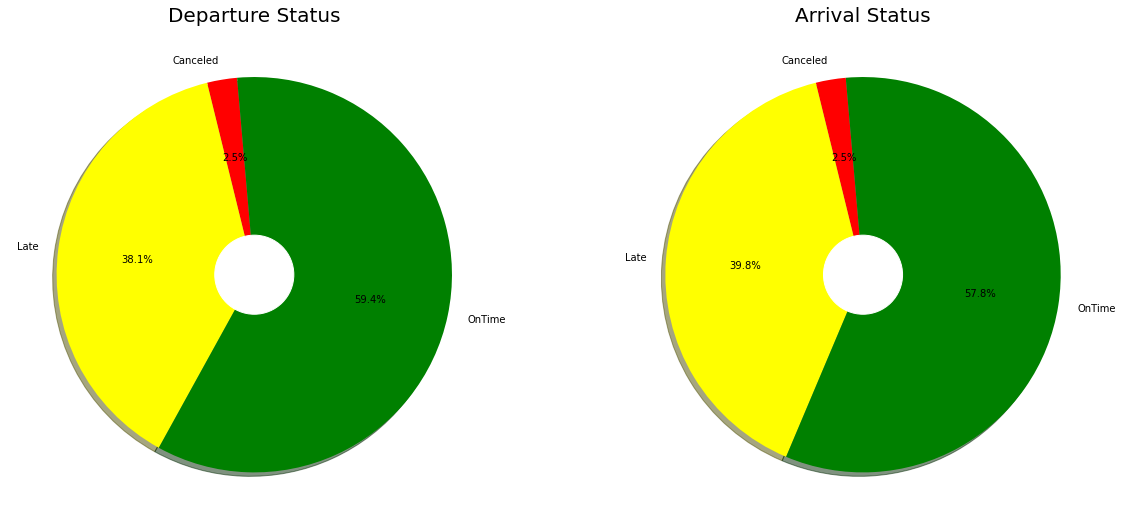

In [17]:
fig = plt.figure(figsize=[20, 20])
ax = fig.add_subplot(221)
ax.pie(depStatus, labeldistance=1.1, labels=depStatus.index, startangle=95, autopct='%1.1f%%', shadow=True, colors=['red','yellow','green'])
ax.set_title("Departure Status", fontsize=20);
plt.gcf().gca().add_artist(plt.Circle( (0,0), 0.2, color='white'))

ax2 = fig.add_subplot(222)
ax2.pie(arrStatus, labeldistance=1.1, labels=arrStatus.index, startangle=95, autopct='%1.1f%%', shadow=True, colors=['red','yellow','green'])
ax2.set_title("Arrival Status", fontsize=20);
plt.gcf().gca().add_artist(plt.Circle( (0,0), 0.2, color='white'))
plt.show()


In [18]:
depAir = df.loc[df['dep_status'] == 'Late'].groupby(['origin','dep_status'])['dep_status'].count().unstack('dep_status')
depAir

dep_status,Canceled,Late,OnTime
origin,,,
EWR,0,52711,0
JFK,0,42031,0
LGA,0,33690,0


In [19]:
arrAir = df.loc[df['arr_status'] == 'Late'].groupby(['origin','arr_status'])['arr_status'].count().unstack('arr_status')
arrAir

arr_status,Canceled,Late,OnTime
origin,,,
EWR,0,50531,0
JFK,0,43182,0
LGA,0,40319,0


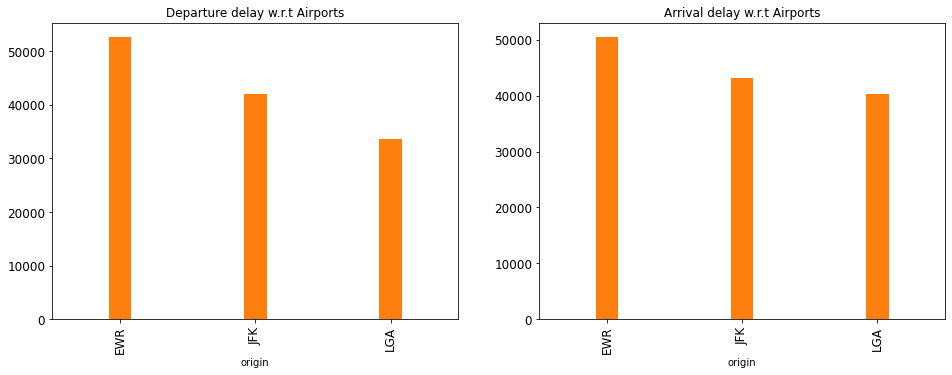

In [20]:
fig = plt.figure(figsize=[16, 12])
ax = fig.add_subplot(221)
depAir.plot(kind='bar', ax=ax, title ="Departure delay w.r.t Airports",  legend=False, fontsize=12)
ax2 = fig.add_subplot(222)
ax.set_facecolor('white')
ax2.set_facecolor('white')
arrAir.plot(kind='bar', ax=ax2, title ="Arrival delay w.r.t Airports",  legend=False, fontsize=12)
plt.show()


In [21]:
depAirPer = df.groupby('origin')['origin'].count().reset_index(name='total')
delayedFlights = df.loc[df['dep_status'] == 'Late'].groupby(['origin','dep_status'])['dep_status'].count().unstack('dep_status')
depAirPer['late'] = delayedFlights['Late'].values
depAirPer['percentage'] = (depAirPer['late']/depAirPer['total'])*100
depAirPer.set_index('origin', inplace=True)
depAirPer

,total,late,percentage
origin,,,
EWR,120835,52711,43.622295
JFK,111279,42031,37.770828
LGA,104662,33690,32.189333


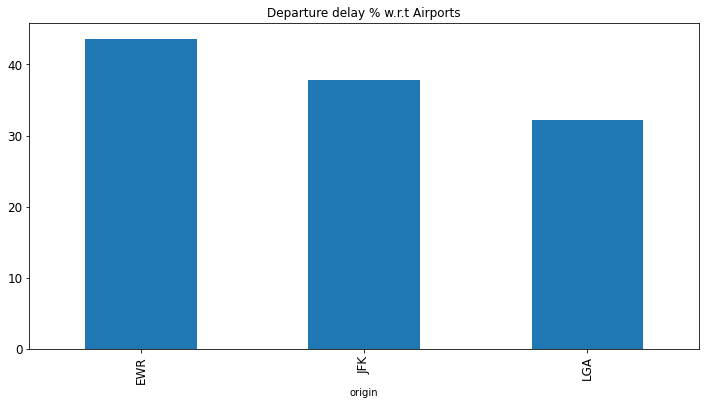

In [22]:
depAirPer['percentage'].plot(kind='bar', figsize=[12,6], title ="Departure delay % w.r.t Airports",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()

In [23]:
depCarrier = df1.loc[df1['dep_status'] == 'Late'].groupby(['carrier','dep_status'])['dep_status'].count().unstack('dep_status')
depCarrier

dep_status,Canceled,Late,OnTime
carrier,,,
9E,0,7063,0
AA,0,10162,0
AS,0,226,0
B6,0,21445,0
DL,0,15241,0
EV,0,23139,0
F9,0,341,0
FL,0,1654,0
HA,0,69,0


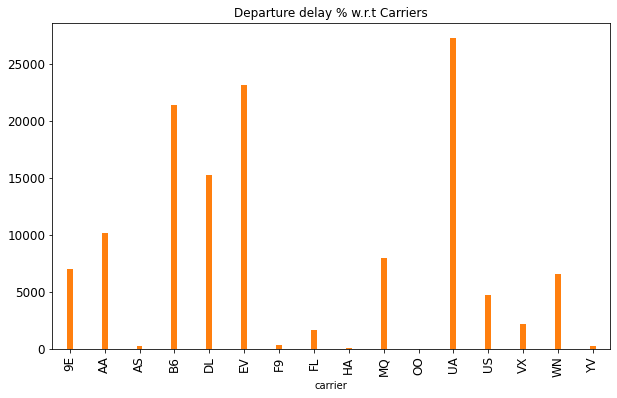

In [24]:
depCarrier.plot(kind='bar', figsize=[10,6], title ="Departure delay % w.r.t Carriers",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()

In [25]:
depCarrierPer = df1.groupby('carrier')['carrier'].count().reset_index(name='total')
delayedFlights = df1.loc[df1['dep_status'] == 'Late'].groupby(['carrier','dep_status'])['dep_status'].count().unstack('dep_status')
depCarrierPer['late'] = delayedFlights['Late'].values
depCarrierPer['percentage'] = (depCarrierPer['late']/depCarrierPer['total'])*100
depCarrierPer.set_index('carrier', inplace=True)
depCarrierPer

,total,late,percentage
carrier,,,
9E,18460,7063,38.261105
AA,32729,10162,31.048917
AS,714,226,31.652661
B6,54635,21445,39.251396
DL,48110,15241,31.679485
EV,54173,23139,42.713160
F9,685,341,49.781022
FL,3260,1654,50.736196
HA,342,69,20.175439


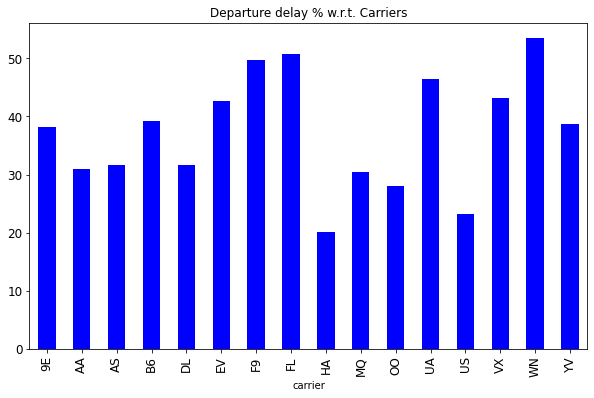

In [26]:
depCarrierPer[['percentage']].plot(kind='bar', figsize=[10,6], title ="Departure delay % w.r.t. Carriers",  legend=False, fontsize=12, color='blue')
plt.gca().set_facecolor('white')
plt.show()

In [27]:
depMonth = df1.loc[df1['dep_status'] == 'Late'].groupby(['month','dep_status'])['dep_status'].count().unstack('dep_status')
depMonth

dep_status,Canceled,Late,OnTime
month,,,
1,0,9662,0
2,0,9124,0
3,0,11209,0
4,0,10543,0
5,0,11291,0
6,0,12655,0
7,0,13909,0
8,0,11713,0
9,0,7815,0


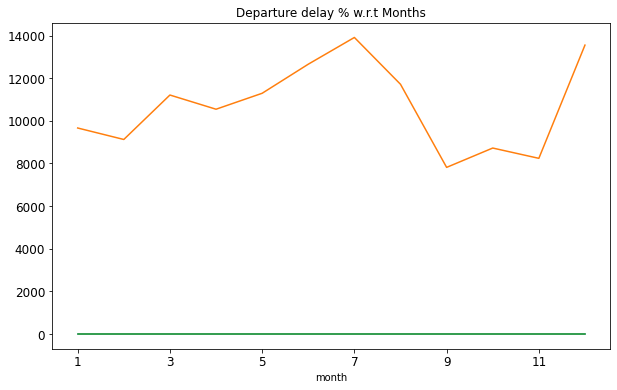

In [28]:
depMonth.plot(figsize=[10,6], title ="Departure delay % w.r.t Months",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()

In [29]:
routeDelay = df.loc[df['dep_status'] == 'Late'].groupby(['origin','dest','dep_status'])['dep_status'].count().reset_index(name='total')
routeDelay = routeDelay[routeDelay.groupby('origin')['total'].transform(max) == routeDelay['total']].sort_values('total')

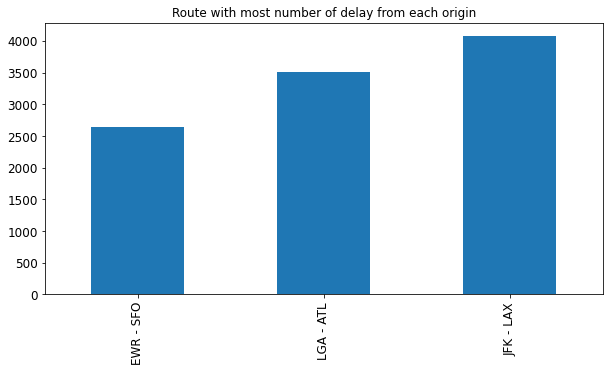

In [30]:
routeDelay.plot(kind='bar', figsize=[10,5], title ="Route with most number of delay from each origin",  legend=False, fontsize=12)
plt.gca().set_xticklabels(routeDelay['origin'].astype(str) + " - "+routeDelay['dest'].astype(str))
plt.gca().set_facecolor('white')
plt.show()

In [31]:
canAir = df.loc[df['dep_status'] == 'Canceled'].groupby(['origin','dep_status'])['dep_status'].count().unstack('dep_status')
canAir

dep_status,Canceled,Late,OnTime
origin,,,
EWR,3239,0,0
JFK,1863,0,0
LGA,3153,0,0


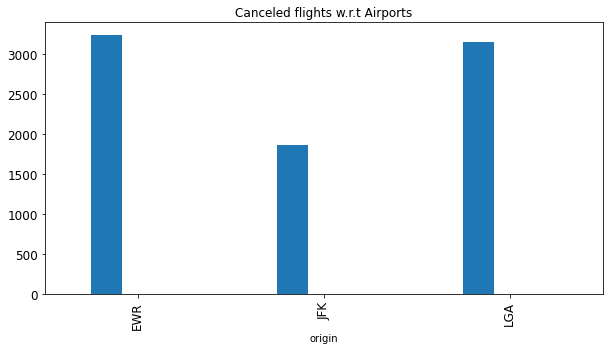

In [32]:
canAir.plot(kind='bar', figsize=[10,5], title ="Canceled flights w.r.t Airports",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()

In [33]:
canAirPer = df.groupby('origin')['origin'].count().reset_index(name='total')
canceledFlights = df1.loc[df1['dep_status'] == 'Canceled'].groupby(['origin','dep_status'])['dep_status'].count().unstack('dep_status')
canAirPer['canceled'] = canceledFlights['Canceled'].values
canAirPer['percentage'] = (canAirPer['canceled']/canAirPer['total'])*100
canAirPer.set_index('origin', inplace=True)
canAirPer

,total,canceled,percentage
origin,,,
EWR,120835,3239,2.680515
JFK,111279,1863,1.674170
LGA,104662,3153,3.012555


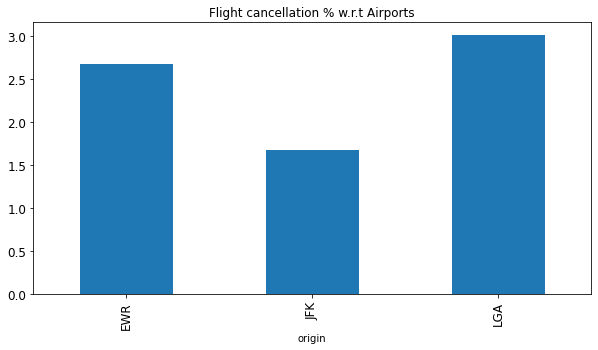

In [34]:
canAirPer['percentage'].plot(kind='bar', figsize=[10,5], title ="Flight cancellation % w.r.t Airports",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()

In [35]:
canCarrier = df.loc[df['dep_status'] == 'Canceled'].groupby(['carrier','dep_status'])['dep_status'].count().unstack('dep_status')
canCarrier

dep_status,Canceled,Late,OnTime
carrier,,,
9E,1044,0,0
AA,636,0,0
AS,2,0,0
B6,466,0,0
DL,349,0,0
EV,2817,0,0
F9,3,0,0
FL,73,0,0
HA,0,0,0


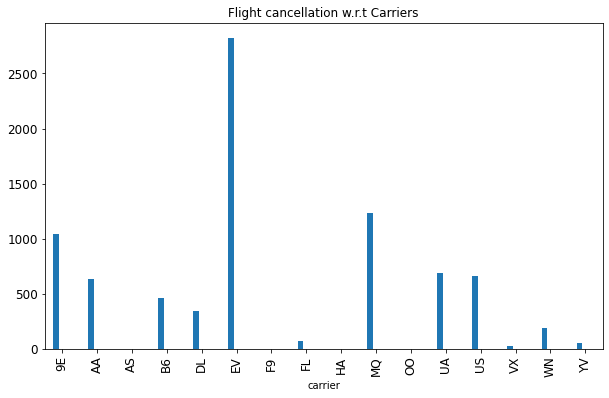

In [36]:
canCarrier.plot(kind='bar', figsize=[10,6], title ="Flight cancellation w.r.t Carriers",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()

In [37]:
canMonth = df1.loc[df['dep_status'] == 'Canceled'].groupby(['month','dep_status'])['dep_status'].count().unstack('dep_status')
canMonth

dep_status,Canceled,Late,OnTime
month,,,
1,521,0,0
2,1261,0,0
3,861,0,0
4,668,0,0
5,563,0,0
6,1009,0,0
7,940,0,0
8,486,0,0
9,452,0,0


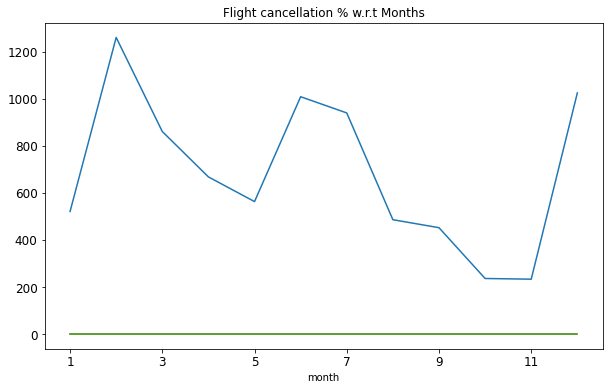

In [38]:
canMonth.plot(figsize=[10,6], title ="Flight cancellation % w.r.t Months",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()

In [39]:
df['speed'] = df['distance']/(df['air_time']/60)
print(df.iloc[df['speed'].idxmax()])
print(df.iloc[df['speed'].idxmin()])

month                           6
day                             1
dep_time          0 days 16:26:00
sched_dep_time    0 days 16:29:00
dep_delay                    -3.0
arr_time          0 days 18:50:00
sched_arr_time    0 days 18:53:00
arr_delay                    -3.0
carrier                        US
flight                         17
origin                        JFK
dest                          PHX
air_time                    144.0
distance                     2153
dep_status                 OnTime
arr_status                 OnTime
speed                  897.083333
Name: 222734, dtype: object
month                           1
day                            13
dep_time          0 days 22:39:00
sched_dep_time    0 days 21:59:00
dep_delay                    40.0
arr_time          0 days 01:10:00
sched_arr_time    0 days 00:30:00
arr_delay                    40.0
carrier                        EV
flight                       4519
origin                        EWR
dest                

In [40]:
flightSpeed = df.groupby(['carrier'])['speed'].mean()
flightSpeed

carrier
9E    344.625846
AA    416.857053
AS    444.459187
B6    399.678786
DL    418.128015
EV    362.338709
F9    425.566706
FL    393.730749
HA    480.357719
MQ    367.912746
OO    366.320085
UA    420.799192
US    341.580788
VX    446.195066
WN    400.254407
YV    331.664615
Name: speed, dtype: float64

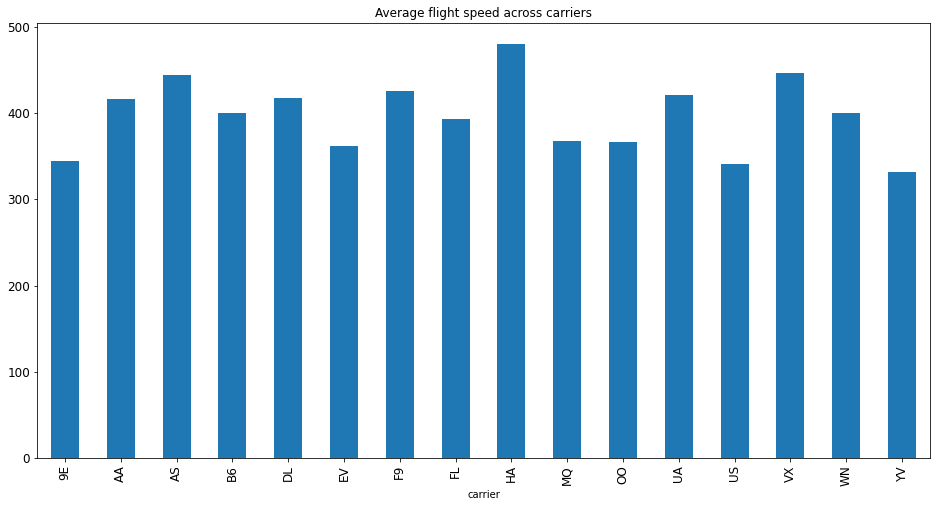

In [41]:
flightSpeed.plot(kind='bar', figsize=[16,8], title ="Average flight speed across carriers",  legend=False, fontsize=12)
plt.gca().set_facecolor('white')
plt.show()